# Chemical engineering PAT project
In this project distillation data of Toluene and Hexane is given, the distillation was performed on industrial scale. The X variable includes data from various sensors.
The Y variable is MoleFractionToluene.

In [ ]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from scipy.optimize import minimize
import shap
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
import optuna
import warnings
import seaborn as sns
import joblib
from sklearn.model_selection import cross_val_score

warnings.filterwarnings('ignore')


# 1. Data loading

In [21]:
file_name='D:/DataScience2023/DataScienceForEngineeringNaturalSciences/1_Chemical_Engineering.csv'
df=pd.read_csv(file_name)

## 1.1 Data exploration and visualization

Check for number of columns and rows

In [22]:
print("\nDataset Shape:", df.shape)


Dataset Shape: (961, 18)


Check data frame data types

In [23]:
df.dtypes

Time                     int64
Sensor1                float64
Sensor2                float64
Sensor3                float64
Sensor4                float64
Sensor5                float64
Sensor6                float64
Sensor7                float64
Sensor8                float64
Sensor9                float64
Sensor10               float64
Sensor11               float64
Sensor12               float64
Sensor13               float64
Sensor14               float64
Sensor15               float64
MoleFractionToluene    float64
MoleFractionHexane     float64
dtype: object

In [24]:
pd.set_option('display.max_columns', None)
df.head(961)

,Time,Sensor1,Sensor2,Sensor3,Sensor4,Sensor5,Sensor6,Sensor7,Sensor8,Sensor9,Sensor10,Sensor11,Sensor12,Sensor13,Sensor14,Sensor15,MoleFractionToluene,MoleFractionHexane
0,0,49.718959,101.414959,49.718959,3693.858959,6695.368959,2924.818959,1048.588959,0.054394,0.501001,0.498999,76.803959,104.148959,110.216959,67.038059,0.798463,0.966281,0.033719
1,30,49.561845,100.962045,49.541545,3712.947045,6629.637045,2767.487045,1046.987045,0.054233,0.501001,0.498999,76.437645,103.977045,110.045045,66.866145,0.800811,0.965788,0.034212
2,60,50.189365,101.490865,50.145165,3718.008865,6692.598865,2763.018865,1050.988865,0.053941,0.501001,0.498999,77.041465,104.608865,110.676865,67.497965,0.803544,0.965758,0.034242
3,90,50.183496,101.403296,50.142796,3721.819296,6702.869296,2754.009296,1051.449296,0.053968,0.501001,0.498999,77.016096,104.609296,110.677296,67.498396,0.807065,0.965756,0.034244
4,120,50.428793,101.603693,50.406093,3724.444693,6710.444693,2744.244693,1052.674693,0.054121,0.501001,0.498999,77.252293,104.864693,110.932693,67.753793,0.811774,0.965784,0.034216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
956,28680,49.604279,100.903579,54.520579,3783.434579,6808.374579,2782.764579,1052.594579,0.054906,0.501001,0.498999,76.467579,104.034579,110.102579,66.923679,0.792092,0.964851,0.035149
957,28710,50.164408,101.465308,55.073908,3783.905308,6809.155308,2782.875308,1053.235308,0.054913,0.501001,0.498999,77.028608,104.595308,110.663308,67.484408,0.792288,0.964852,0.035148
958,28740,50.332178,101.634378,55.234278,3784.033378,6809.343378,2783.673378,1053.403378,0.054925,0.501001,0.498999,77.196878,104.763378,110.831378,67.652478,0.792515,0.964853,0.035147
959,28770,50.080385,101.384285,54.974485,3783.671285,6808.931285,2782.991285,1053.181285,0.054930,0.501001,0.498999,76.944985,104.511285,110.579285,67.400385,0.792525,0.964853,0.035147


Describe the data to get overall information about data

In [25]:
df.describe()

,Time,Sensor1,Sensor2,Sensor3,Sensor4,Sensor5,Sensor6,Sensor7,Sensor8,Sensor9,Sensor10,Sensor11,Sensor12,Sensor13,Sensor14,Sensor15,MoleFractionToluene,MoleFractionHexane
count,961.000000,961.000000,961.000000,961.000000,961.000000,961.000000,961.000000,961.000000,961.000000,9.610000e+02,9.610000e+02,961.000000,961.000000,961.000000,961.000000,961.000000,961.000000,961.000000
mean,14400.000000,49.994889,101.279649,49.555769,3823.335379,6865.768293,2805.781415,1053.164047,0.055029,5.010010e-01,4.989990e-01,76.835812,104.424765,110.492765,67.313865,0.809068,0.964015,0.035985
std,8326.833132,0.292281,0.452364,6.118368,511.213381,755.410384,259.579392,4.997380,0.003787,2.221602e-16,1.110801e-16,0.334343,0.280159,0.280159,0.280159,0.161491,0.008473,0.008473
min,0.000000,48.907668,97.702103,36.812829,3004.403494,5653.363002,2134.576770,1013.589114,0.028320,5.010010e-01,4.989990e-01,75.991528,103.930595,109.998595,66.819695,0.571794,0.950885,0.022401
25%,7200.000000,49.754926,101.033896,44.564921,3408.090531,6252.664563,2601.983148,1049.884770,0.053854,5.010010e-01,4.989990e-01,76.601021,104.183922,110.251922,67.073022,0.639547,0.957287,0.028810
50%,14400.000000,50.001056,101.296977,50.455106,3722.752040,6718.275361,2756.461191,1053.220322,0.054807,5.010010e-01,4.989990e-01,76.832795,104.426582,110.494582,67.315682,0.807521,0.965902,0.034098
75%,21600.000000,50.225012,101.539019,54.766717,4450.433352,7406.035409,3111.691346,1055.451884,0.056485,5.010010e-01,4.989990e-01,77.085614,104.649155,110.717155,67.538255,0.914706,0.971190,0.042713
max,28800.000000,50.807513,103.848213,57.890626,4562.816420,7957.048708,3300.394030,1084.786368,0.084926,5.010010e-01,4.989990e-01,77.891430,104.929458,110.997458,67.818558,1.644580,0.977599,0.049115


Get coorelation matrix for MoleFractionToluene

In [26]:
target = 'MoleFractionToluene'
correlations = df.corr()[target].sort_values(ascending=False)
print("Correlations with target:\n", correlations)

Correlations with target:
 MoleFractionToluene    1.000000
Sensor15               0.887787
Sensor7                0.590367
Time                   0.516353
Sensor1                0.031536
Sensor2                0.026545
Sensor13               0.020722
Sensor12               0.020722
Sensor14               0.020722
Sensor8               -0.226468
Sensor11              -0.481795
Sensor3               -0.815105
Sensor6               -0.941967
Sensor4               -0.959240
Sensor5               -0.961166
MoleFractionHexane    -1.000000
Sensor9                     NaN
Sensor10                    NaN
Name: MoleFractionToluene, dtype: float64


Draw a correlation heatmap

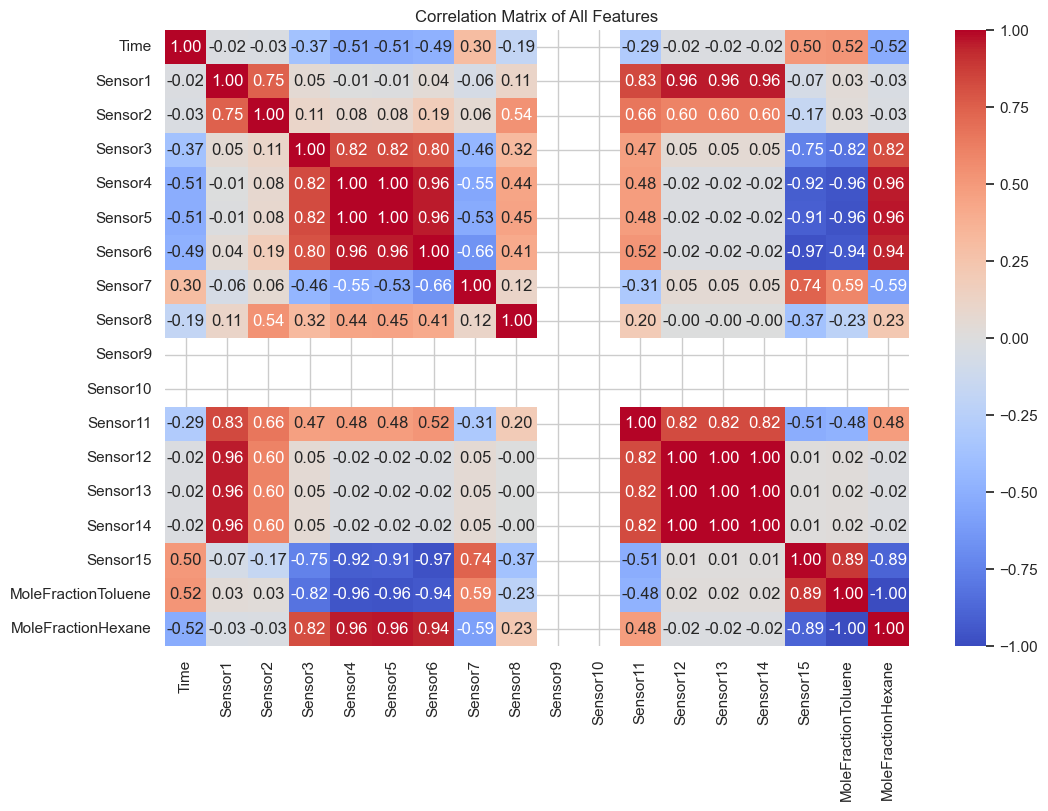

In [27]:
# Correlation Matrix
plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix of All Features")
plt.show()


Check for number of entries in each column

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Time                 961 non-null    int64  
 1   Sensor1              961 non-null    float64
 2   Sensor2              961 non-null    float64
 3   Sensor3              961 non-null    float64
 4   Sensor4              961 non-null    float64
 5   Sensor5              961 non-null    float64
 6   Sensor6              961 non-null    float64
 7   Sensor7              961 non-null    float64
 8   Sensor8              961 non-null    float64
 9   Sensor9              961 non-null    float64
 10  Sensor10             961 non-null    float64
 11  Sensor11             961 non-null    float64
 12  Sensor12             961 non-null    float64
 13  Sensor13             961 non-null    float64
 14  Sensor14             961 non-null    float64
 15  Sensor15             961 non-null    flo

Check for any empty/null values

In [29]:
print("\nMissing values in each column:")
print(df.isnull().sum())


Missing values in each column:
Time                   0
Sensor1                0
Sensor2                0
Sensor3                0
Sensor4                0
Sensor5                0
Sensor6                0
Sensor7                0
Sensor8                0
Sensor9                0
Sensor10               0
Sensor11               0
Sensor12               0
Sensor13               0
Sensor14               0
Sensor15               0
MoleFractionToluene    0
MoleFractionHexane     0
dtype: int64


See distribution of data by drawing histogram

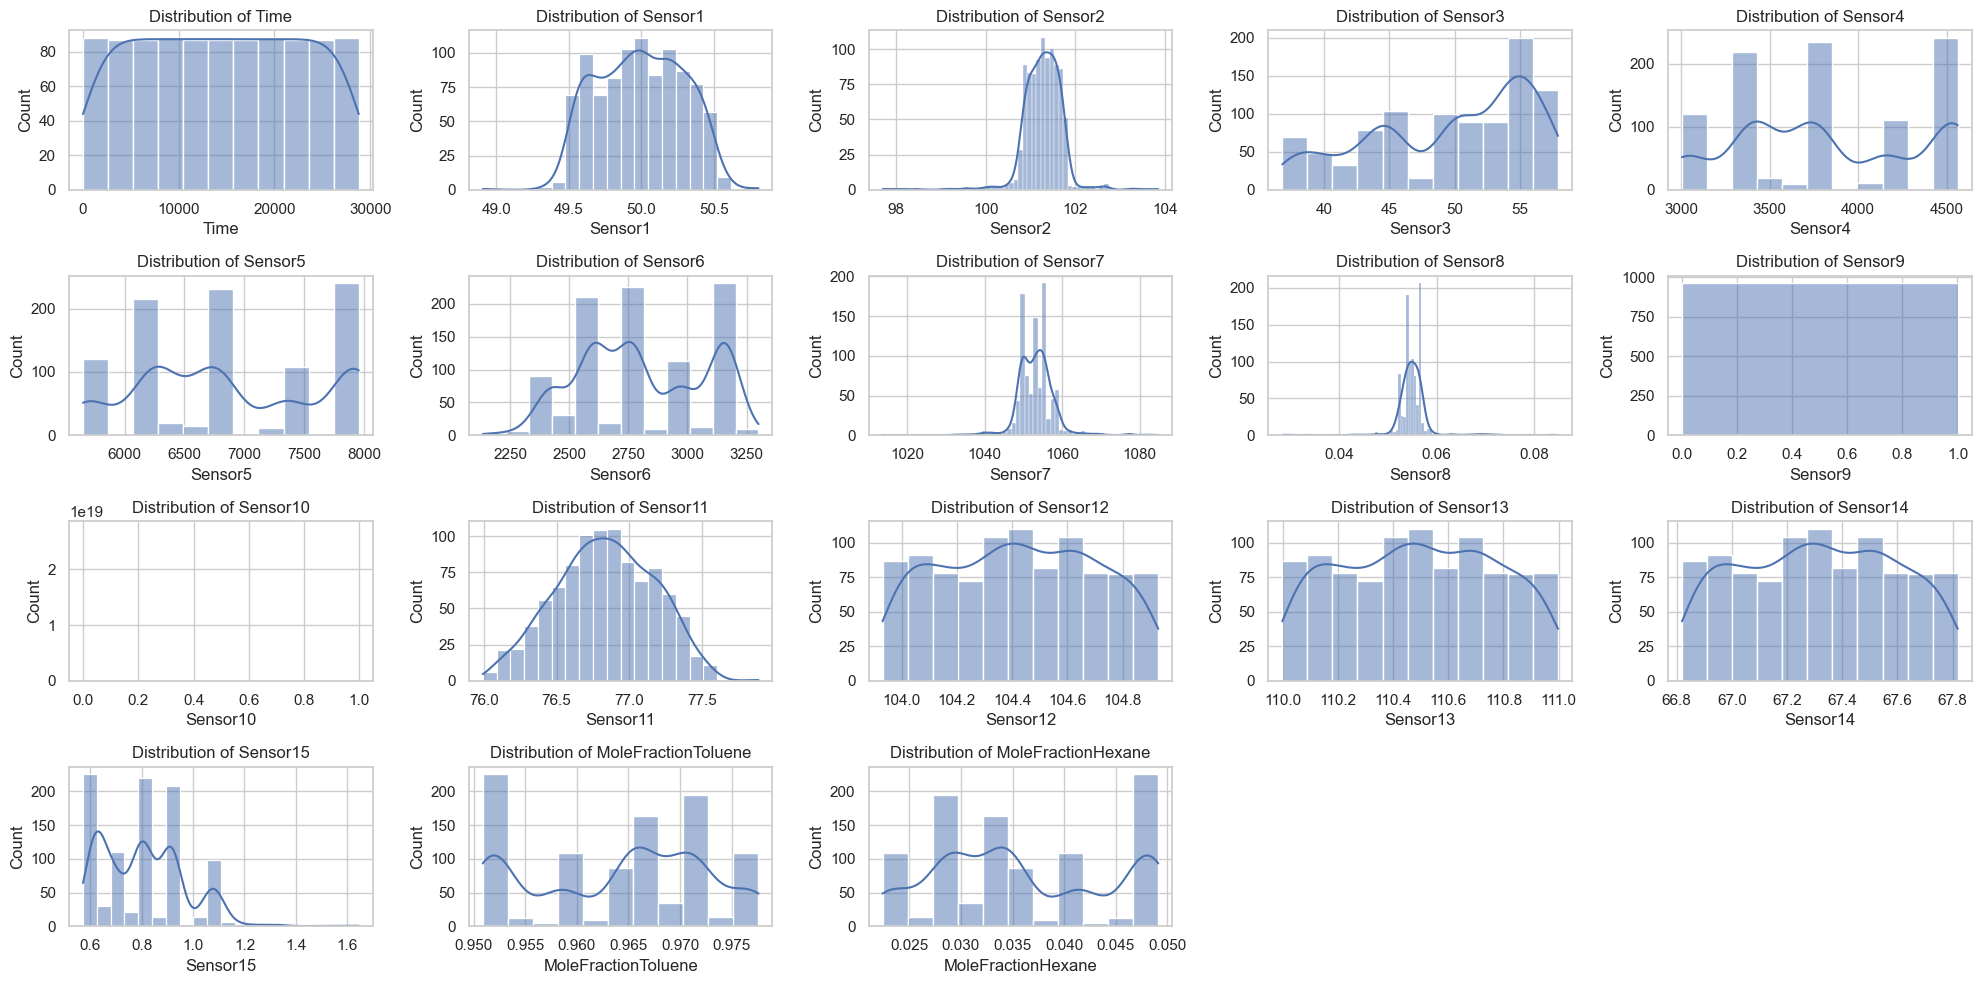

In [30]:
sns.set(style="whitegrid")
plt.figure(figsize=(20, 10))
for i, column in enumerate(df.columns, 1):  # Start from the first column
  plt.subplot(4, 5, i)  # Adjust the layout if needed (e.g., 4 rows by 5 columns)
  sns.histplot(df[column], kde=True)
  plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

Draw pair plot for variables of interest

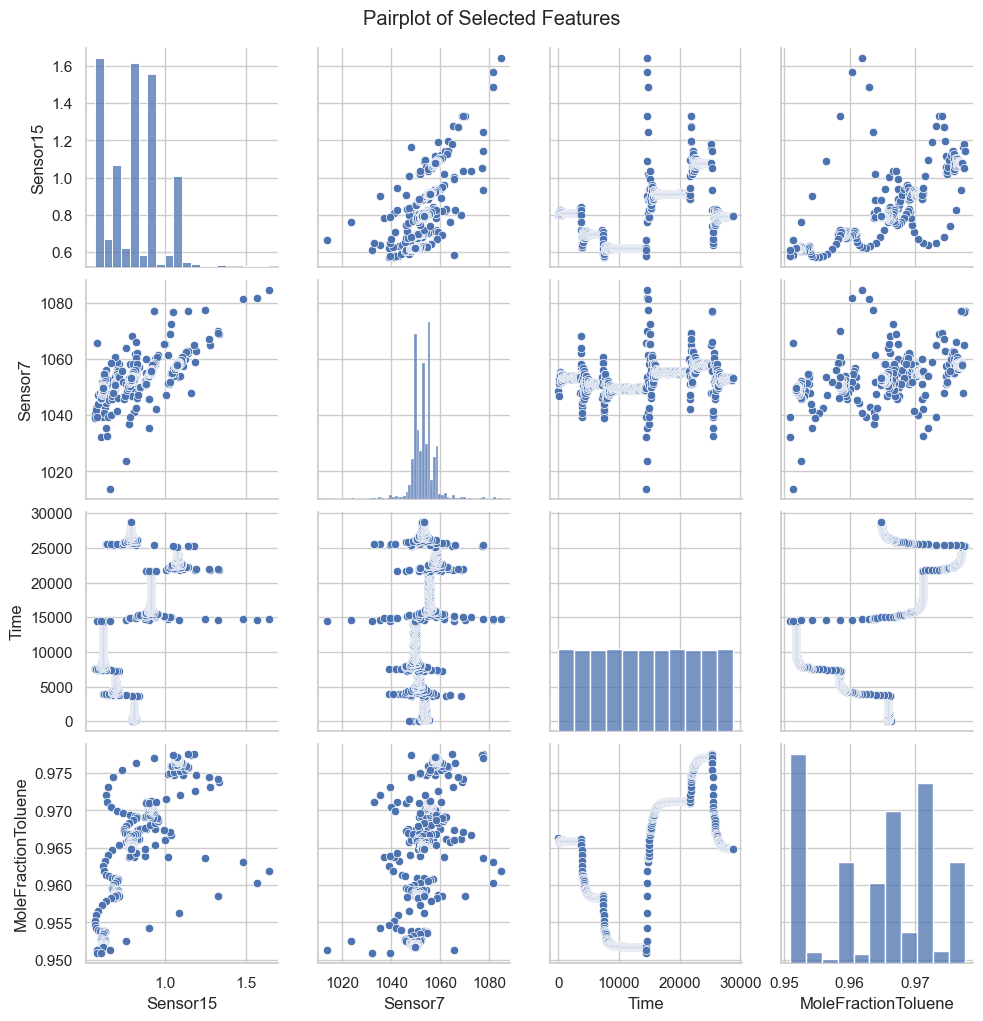

In [31]:
sns.pairplot(df[['Sensor15', 'Sensor7', 'Time', 'MoleFractionToluene']])
plt.suptitle("Pairplot of Selected Features", y=1.02)
plt.show()

Scatter plot between MoleFractionToluene and Sensor15

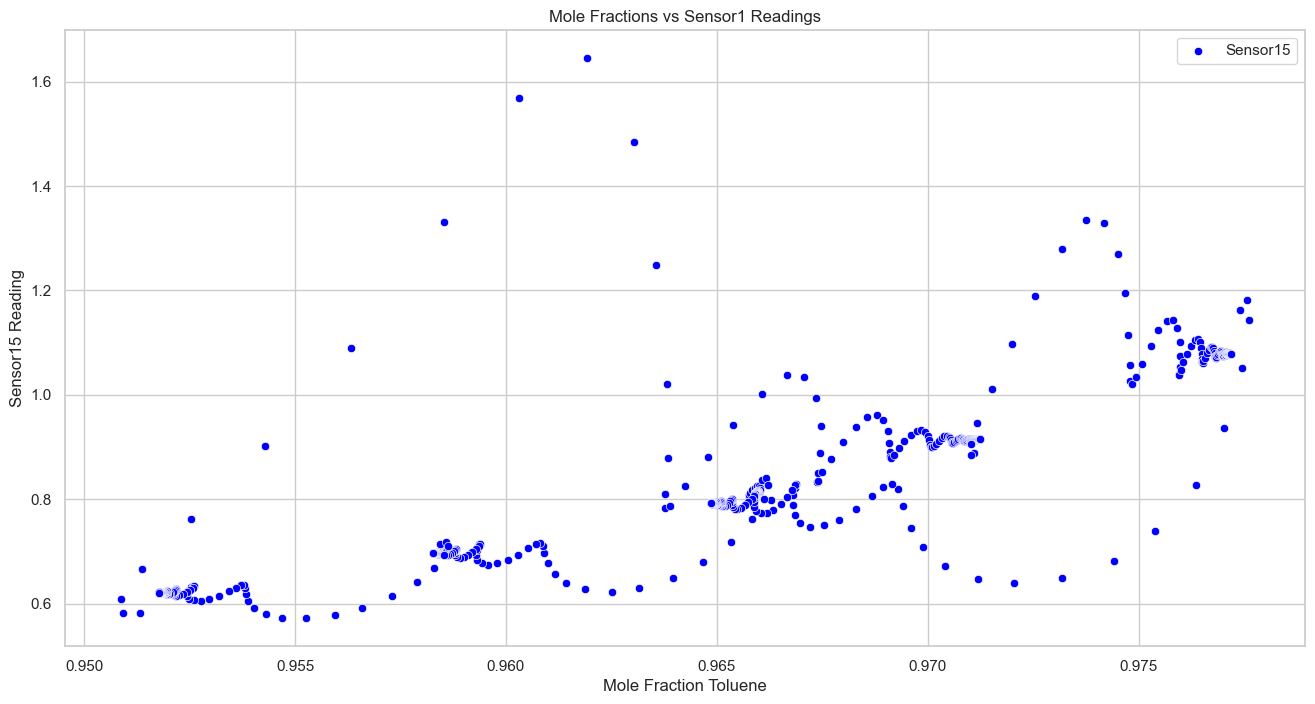

In [32]:

# Scatter plot of Mole Fractions vs Sensor Readings
plt.figure(figsize=(16, 8))
sns.scatterplot(x='MoleFractionToluene', y='Sensor15', data=df, label='Sensor15', color="blue")
plt.xlabel("Mole Fraction Toluene")
plt.ylabel("Sensor15 Reading")
plt.legend()
plt.title("Mole Fractions vs Sensor1 Readings")
plt.show()

# 2. Data preprocessing

exclude the columns that have negative correlation with Y variable

In [33]:
positive_correlated_features = correlations[correlations > 0].index.tolist()
positive_correlated_features.remove(target)  # Remove the target itself from the list

Feature selection

In [34]:
X = df[positive_correlated_features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Model development
Model development and evaluation

In [ ]:
# Define baseline models
models = {
  'Linear Regression': LinearRegression(),
  'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
  'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

# Evaluate baseline models using cross-validation
for name, model in models.items():
  cv_score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
  print(f"{name} Baseline CV RMSE: {np.sqrt(-cv_score.mean()):.4f}")

## 3.1 Model tunning and re-evaluation

In [35]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import optuna
import numpy as np

# Define baseline models
models = {
  'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
  'Gradient Boosting': GradientBoostingRegressor(random_state=42),
  'SVR': SVR()
}

# Evaluate baseline models using cross-validation
for name, model in models.items():
  cv_score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
  print(f"{name} Baseline CV RMSE: {np.sqrt(-cv_score.mean()):.4f}")

# Hyperparameter Tuning with Optuna for Random Forest
def rf_objective(trial):
  n_estimators = trial.suggest_int('n_estimators', 50, 200)
  max_depth = trial.suggest_int('max_depth', 5, 20)
  min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
  
  model = RandomForestRegressor(
      n_estimators=n_estimators,
      max_depth=max_depth,
      min_samples_split=min_samples_split,
      random_state=42
  )
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  return rmse

rf_study = optuna.create_study(direction='minimize')
rf_study.optimize(rf_objective, n_trials=50)
print("Best Random Forest parameters:", rf_study.best_params)

# Gradient Boosting Tuning with Optuna
def gb_objective(trial):
  n_estimators = trial.suggest_int('n_estimators', 50, 200)
  max_depth = trial.suggest_int('max_depth', 3, 10)
  learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
  min_samples_split = trial.suggest_int('min_samples_split', 2, 10)

  model = GradientBoostingRegressor(
      n_estimators=n_estimators,
      max_depth=max_depth,
      learning_rate=learning_rate,
      min_samples_split=min_samples_split,
      random_state=42
  )
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  return rmse

gb_study = optuna.create_study(direction='minimize')
gb_study.optimize(gb_objective, n_trials=50)
print("Best Gradient Boosting parameters:", gb_study.best_params)

# SVR Tuning with Optuna
def svr_objective(trial):
  C = trial.suggest_loguniform('C', 1e-3, 1e3)
  epsilon = trial.suggest_loguniform('epsilon', 1e-3, 1e1)
  kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])

  model = SVR(C=C, epsilon=epsilon, kernel=kernel)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  return rmse

svr_study = optuna.create_study(direction='minimize')
svr_study.optimize(svr_objective, n_trials=50)
print("Best SVR parameters:", svr_study.best_params)

# Train Final Tuned Models
optimized_models = {
  'SVR': SVR(**svr_study.best_params),
  'Random Forest': RandomForestRegressor(**rf_study.best_params, random_state=42),
  'Gradient Boosting': GradientBoostingRegressor(**gb_study.best_params, random_state=42)
}

# Evaluate optimized models
for name, model in optimized_models.items():
  cv_score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
  print(f"{name} Tuned CV RMSE: {np.sqrt(-cv_score.mean()):.4f}")
  
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  test_r2 = r2_score(y_test, y_pred)
  
  print(f"{name} Test RMSE: {test_rmse:.4f}")
  print(f"{name} Test R2 Score: {test_r2:.4f}")

Random Forest Baseline CV RMSE: 0.0009


[I 2024-11-13 22:18:51,125] A new study created in memory with name: no-name-e0389f98-3ecb-4992-8724-e1ff85cbb065


Gradient Boosting Baseline CV RMSE: 0.0006
SVR Baseline CV RMSE: 0.0085


[I 2024-11-13 22:18:52,152] Trial 0 finished with value: 0.0006598771730754127 and parameters: {'n_estimators': 191, 'max_depth': 19, 'min_samples_split': 6}. Best is trial 0 with value: 0.0006598771730754127.
[I 2024-11-13 22:18:52,934] Trial 1 finished with value: 0.000746433511179138 and parameters: {'n_estimators': 200, 'max_depth': 7, 'min_samples_split': 10}. Best is trial 0 with value: 0.0006598771730754127.
[I 2024-11-13 22:18:53,452] Trial 2 finished with value: 0.0005974575757125689 and parameters: {'n_estimators': 131, 'max_depth': 7, 'min_samples_split': 3}. Best is trial 2 with value: 0.0005974575757125689.
[I 2024-11-13 22:18:54,073] Trial 3 finished with value: 0.000739342703398807 and parameters: {'n_estimators': 123, 'max_depth': 15, 'min_samples_split': 9}. Best is trial 2 with value: 0.0005974575757125689.
[I 2024-11-13 22:18:54,439] Trial 4 finished with value: 0.0007424663217479168 and parameters: {'n_estimators': 70, 'max_depth': 17, 'min_samples_split': 7}. Best 

Best Random Forest parameters: {'n_estimators': 194, 'max_depth': 12, 'min_samples_split': 2}


[I 2024-11-13 22:19:38,763] Trial 0 finished with value: 0.000379824116406954 and parameters: {'n_estimators': 92, 'max_depth': 6, 'learning_rate': 0.14429567708799546, 'min_samples_split': 9}. Best is trial 0 with value: 0.000379824116406954.
[I 2024-11-13 22:19:39,384] Trial 1 finished with value: 0.00048211006502507387 and parameters: {'n_estimators': 184, 'max_depth': 4, 'learning_rate': 0.1415153322286106, 'min_samples_split': 3}. Best is trial 0 with value: 0.000379824116406954.
[I 2024-11-13 22:19:40,003] Trial 2 finished with value: 0.0004076446490509991 and parameters: {'n_estimators': 135, 'max_depth': 6, 'learning_rate': 0.23479757952692704, 'min_samples_split': 9}. Best is trial 0 with value: 0.000379824116406954.
[I 2024-11-13 22:19:40,552] Trial 3 finished with value: 0.0004471522115259298 and parameters: {'n_estimators': 133, 'max_depth': 5, 'learning_rate': 0.25695803129033334, 'min_samples_split': 7}. Best is trial 0 with value: 0.000379824116406954.
[I 2024-11-13 22:1

Best Gradient Boosting parameters: {'n_estimators': 164, 'max_depth': 8, 'learning_rate': 0.07900110308427676, 'min_samples_split': 4}


[I 2024-11-13 22:20:24,687] Trial 2 finished with value: 0.007104463884974142 and parameters: {'C': 0.7301023639678552, 'epsilon': 0.002149753515965342, 'kernel': 'poly'}. Best is trial 2 with value: 0.007104463884974142.
[I 2024-11-13 22:20:24,692] Trial 3 finished with value: 0.008324703385152961 and parameters: {'C': 806.2162379790761, 'epsilon': 0.634844847627157, 'kernel': 'poly'}. Best is trial 2 with value: 0.007104463884974142.
[I 2024-11-13 22:20:24,698] Trial 4 finished with value: 0.00832470338515295 and parameters: {'C': 0.005856198561823269, 'epsilon': 0.437438560561478, 'kernel': 'sigmoid'}. Best is trial 2 with value: 0.007104463884974142.
[I 2024-11-13 22:20:24,707] Trial 5 finished with value: 0.0035471390796770787 and parameters: {'C': 0.5158181536375459, 'epsilon': 0.00593556327611309, 'kernel': 'rbf'}. Best is trial 5 with value: 0.0035471390796770787.
[I 2024-11-13 22:20:24,753] Trial 6 finished with value: 0.4358016487610823 and parameters: {'C': 0.020596937112839

Best SVR parameters: {'C': 0.3941725633143708, 'epsilon': 0.0015165167500822566, 'kernel': 'rbf'}
SVR Tuned CV RMSE: 0.0029
SVR Test RMSE: 0.0031
SVR Test R2 Score: 0.8642
Random Forest Tuned CV RMSE: 0.0009
Random Forest Test RMSE: 0.0005
Random Forest Test R2 Score: 0.9959
Gradient Boosting Tuned CV RMSE: 0.0008
Gradient Boosting Test RMSE: 0.0003
Gradient Boosting Test R2 Score: 0.9991


## 3.2 Model tunning insight using plotly and optuna

In [39]:
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_parallel_coordinate, plot_slice

# Function to update plot layout with RMSE label
def update_plot_layout(fig, title):
  fig.update_layout(
      title=title,
      yaxis_title='RMSE'
  )
  return fig

# Visualize Random Forest Tuning
print("Visualizing Random Forest Tuning...")
rf_optimization_history = plot_optimization_history(rf_study)
rf_param_importances = plot_param_importances(rf_study)
rf_parallel_coordinate = plot_parallel_coordinate(rf_study)
rf_slice = plot_slice(rf_study)

# Update plots with RMSE label
rf_optimization_history = update_plot_layout(rf_optimization_history, "Random Forest Optimization History")
rf_param_importances = update_plot_layout(rf_param_importances, "Random Forest Parameter Importances")
rf_parallel_coordinate = update_plot_layout(rf_parallel_coordinate, "Random Forest Parallel Coordinate")
rf_slice = update_plot_layout(rf_slice, "Random Forest Slice")

# Show the plots
rf_optimization_history.show()
rf_param_importances.show()
rf_parallel_coordinate.show()
rf_slice.show()

# Visualize Gradient Boosting Tuning
print("Visualizing Gradient Boosting Tuning...")
gb_optimization_history = plot_optimization_history(gb_study)
gb_param_importances = plot_param_importances(gb_study)
gb_parallel_coordinate = plot_parallel_coordinate(gb_study)
gb_slice = plot_slice(gb_study)

# Update plots with RMSE label
gb_optimization_history = update_plot_layout(gb_optimization_history, "Gradient Boosting Optimization History")
gb_param_importances = update_plot_layout(gb_param_importances, "Gradient Boosting Parameter Importances")
gb_parallel_coordinate = update_plot_layout(gb_parallel_coordinate, "Gradient Boosting Parallel Coordinate")
gb_slice = update_plot_layout(gb_slice, "Gradient Boosting Slice")

# Show the plots
gb_optimization_history.show()
gb_param_importances.show()
gb_parallel_coordinate.show()
gb_slice.show()

# Visualize SVR Tuning
print("Visualizing SVR Tuning...")
svr_optimization_history = plot_optimization_history(svr_study)
svr_param_importances = plot_param_importances(svr_study)
svr_parallel_coordinate = plot_parallel_coordinate(svr_study)
svr_slice = plot_slice(svr_study)

# Update plots with RMSE label
svr_optimization_history = update_plot_layout(svr_optimization_history, "SVR Optimization History")
svr_param_importances = update_plot_layout(svr_param_importances, "SVR Parameter Importances")
svr_parallel_coordinate = update_plot_layout(svr_parallel_coordinate, "SVR Parallel Coordinate")
svr_slice = update_plot_layout(svr_slice, "SVR Slice")

# Show the plots
svr_optimization_history.show()
svr_param_importances.show()
svr_parallel_coordinate.show()
svr_slice.show()

Visualizing Random Forest Tuning...


Visualizing Gradient Boosting Tuning...


Visualizing SVR Tuning...


## 3.3 Save best models

In [ ]:
joblib.dump(optimized_models['SVR'], 'D:/DataScience2023/DataScienceForEngineeringNaturalSciences/optimized_svr_model.pkl')
joblib.dump(optimized_models['Random Forest'], 'D:/DataScience2023/DataScienceForEngineeringNaturalSciences/optimized_random_forest_model.pkl')
joblib.dump(optimized_models['Gradient Boosting'], 'D:/DataScience2023/DataScienceForEngineeringNaturalSciences/optimized_gradient_boosting_model.pkl')
print("Models saved successfully.")

# 4. Getting optimized X parameters, validation of optimized parameters, SHAP analysis, and sensitivity of each feature in regression models
Convert feature_values to a DataFrame with the same structure as X_test, Predict the toluene concentration using the optimized model, Since scipy.optimize minimizes by default so return the negative of the prediction.

Using 193 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Models saved successfully.

Optimization Analysis for SVR
Optimal feature values: [7.92462057e-01 1.05273496e+03 1.46636269e+04 4.99822273e+01
 1.01268232e+02 1.10472699e+02 1.04404699e+02 6.72937988e+01]
Predicted maximum concentration: 0.959597524908598
Optimal Feature Settings:
Sensor15: 0.7924620569948186
Sensor7: 1052.7349578134717
Time: 14663.626943005182
Sensor1: 49.98222726523316
Sensor2: 101.2682324453886
Sensor13: 110.47269876632124
Sensor12: 104.40469876632125
Sensor14: 67.29379876782383
All optimal settings are within operational constraints.


  0%|          | 0/193 [00:00<?, ?it/s]

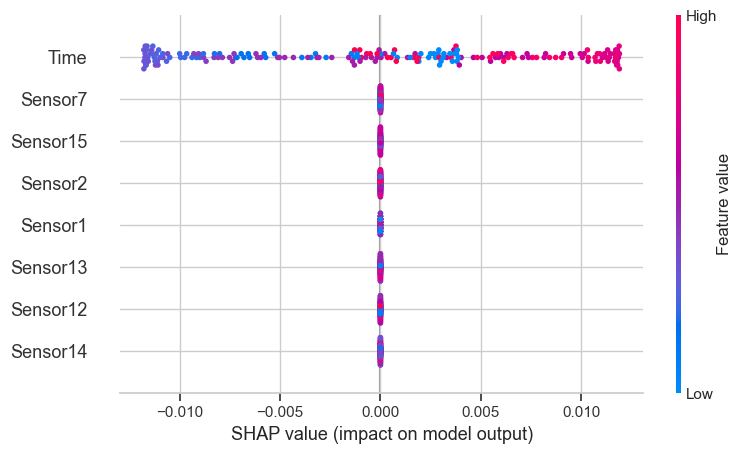


Sensitivity Analysis for SVR


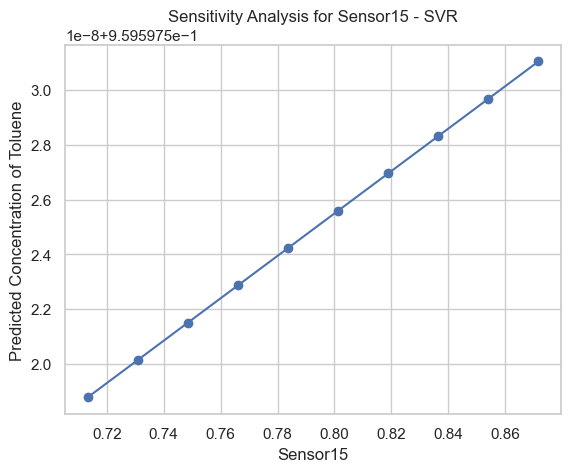

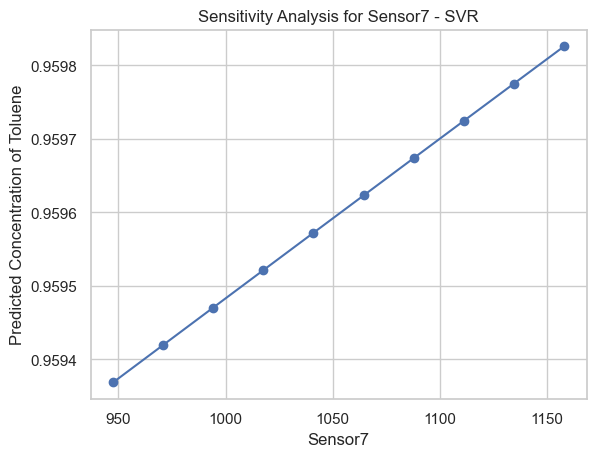

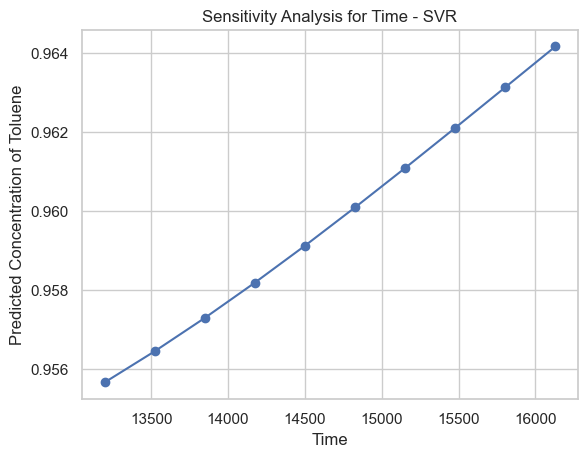

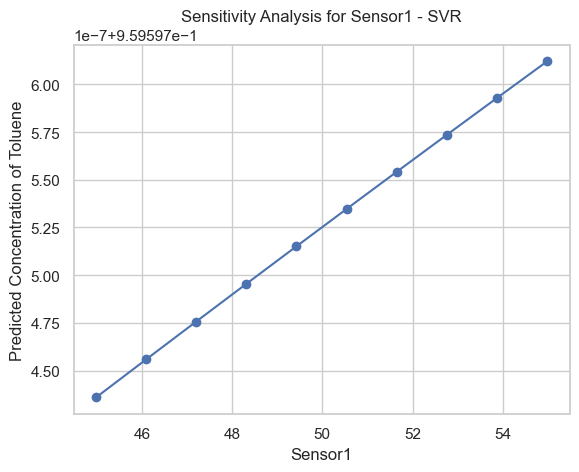

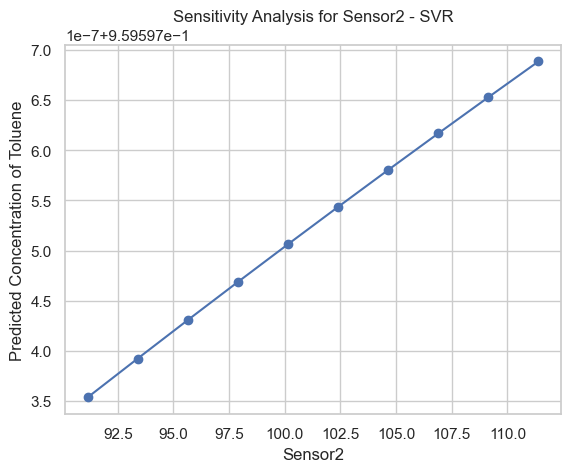

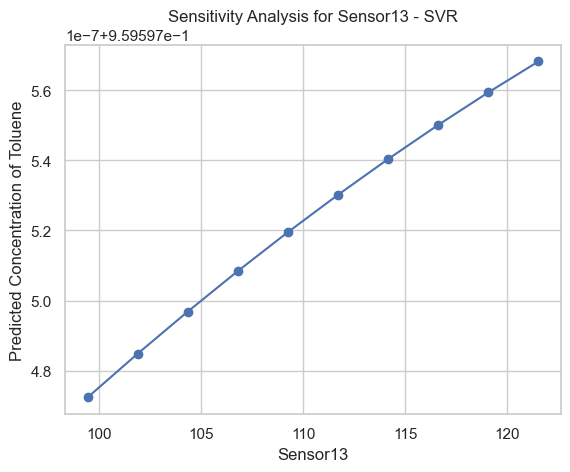

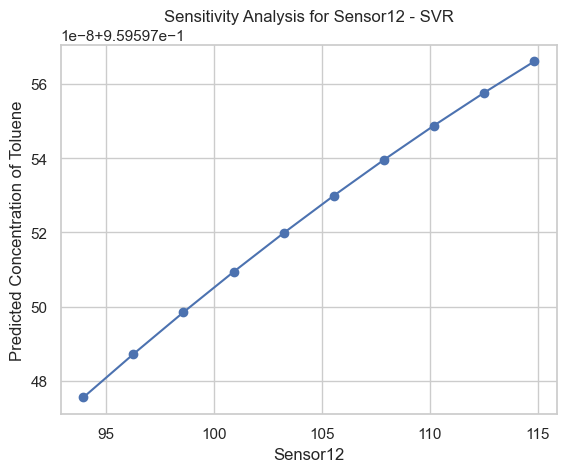

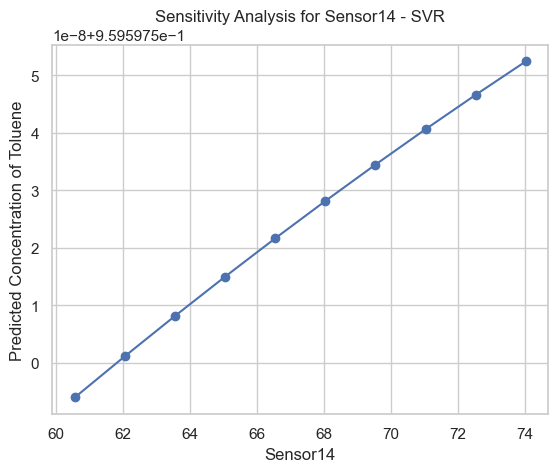


Optimization Analysis for Random Forest
Optimal feature values: [7.92462057e-01 1.05273496e+03 1.46636269e+04 4.99822273e+01
 1.01268232e+02 1.10472699e+02 1.04404699e+02 6.72937988e+01]
Predicted maximum concentration: 0.9653554794327854
Optimal Feature Settings:
Sensor15: 0.7924620569948186
Sensor7: 1052.7349578134717
Time: 14663.626943005182
Sensor1: 49.98222726523316
Sensor2: 101.2682324453886
Sensor13: 110.47269876632124
Sensor12: 104.40469876632125
Sensor14: 67.29379876782383
All optimal settings are within operational constraints.


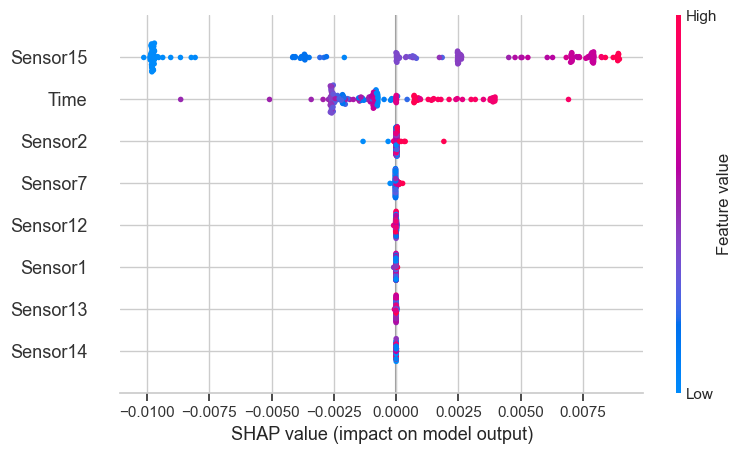


Sensitivity Analysis for Random Forest


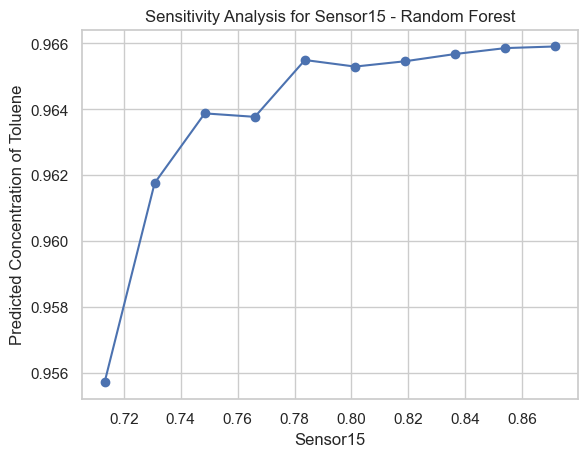

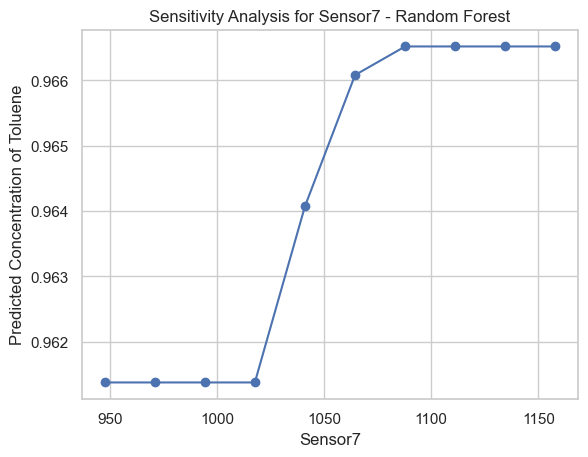

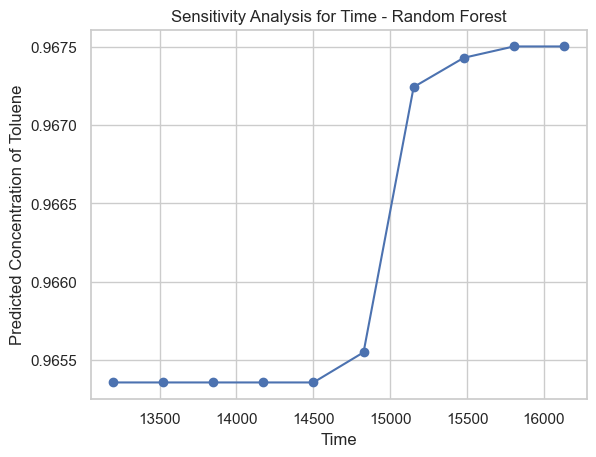

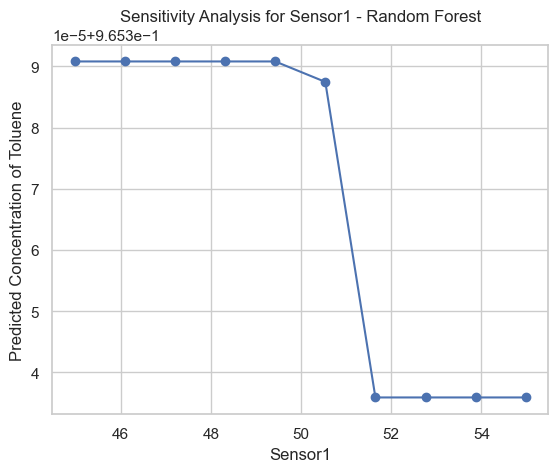

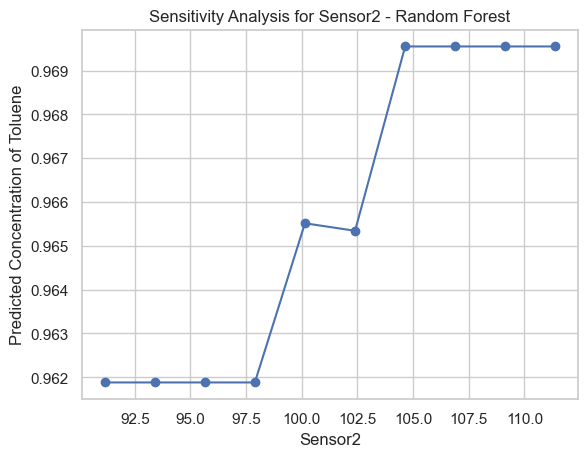

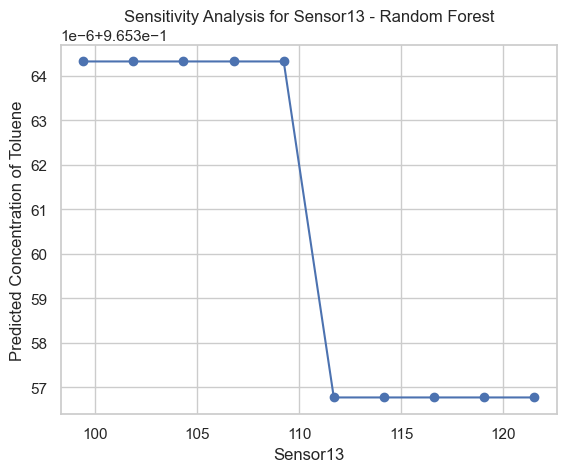

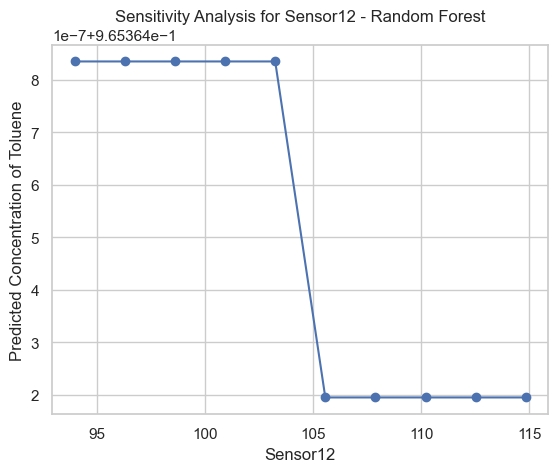

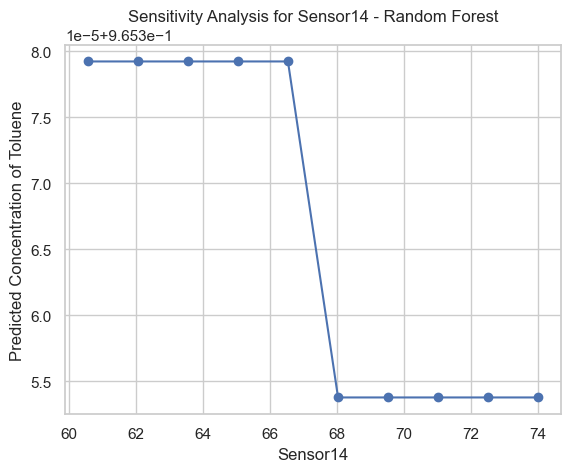


Optimization Analysis for Gradient Boosting
Optimal feature values: [7.92462057e-01 1.05273496e+03 1.46636269e+04 4.99822273e+01
 1.01268232e+02 1.10472699e+02 1.04404699e+02 6.72937988e+01]
Predicted maximum concentration: 0.9649037862097709
Optimal Feature Settings:
Sensor15: 0.7924620569948186
Sensor7: 1052.7349578134717
Time: 14663.626943005182
Sensor1: 49.98222726523316
Sensor2: 101.2682324453886
Sensor13: 110.47269876632124
Sensor12: 104.40469876632125
Sensor14: 67.29379876782383
All optimal settings are within operational constraints.


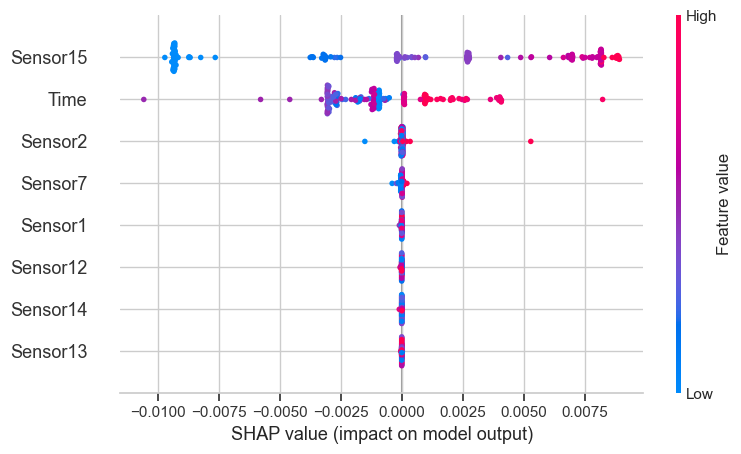


Sensitivity Analysis for Gradient Boosting


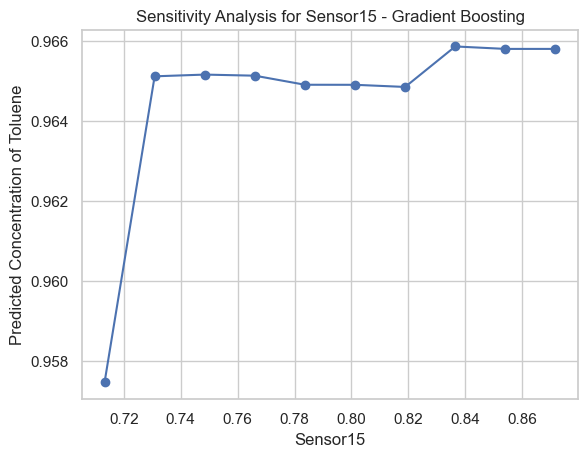

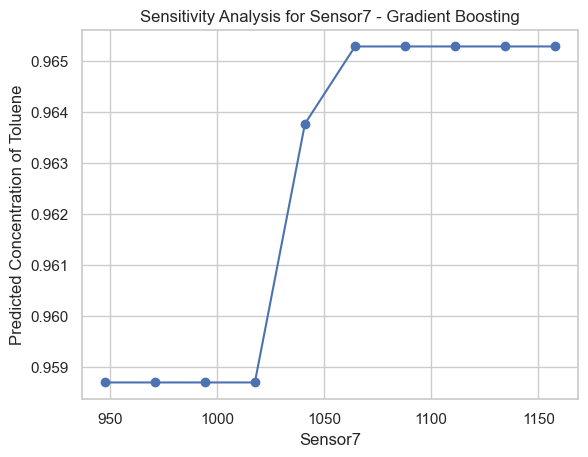

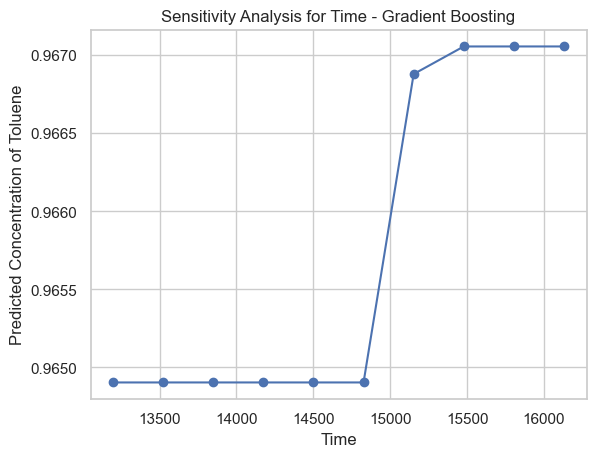

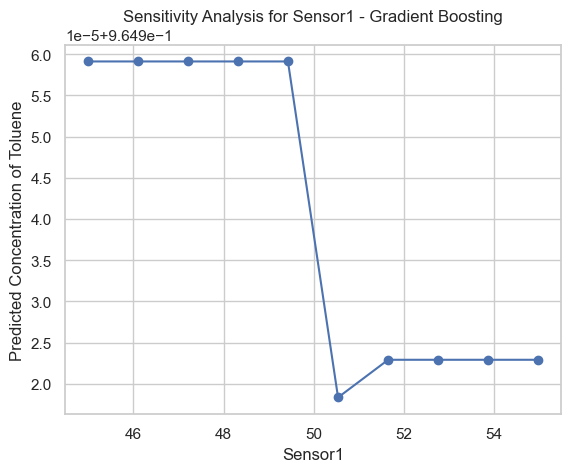

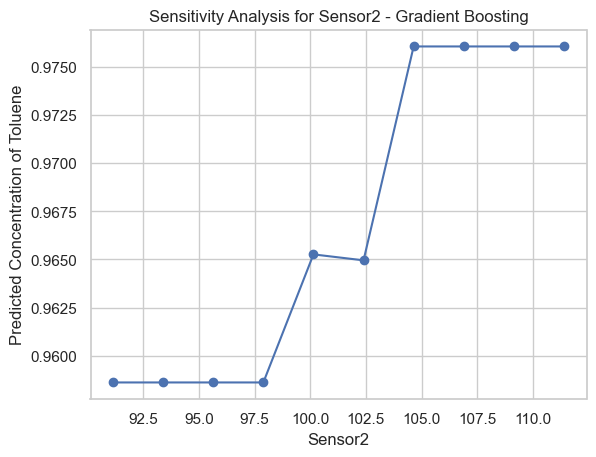

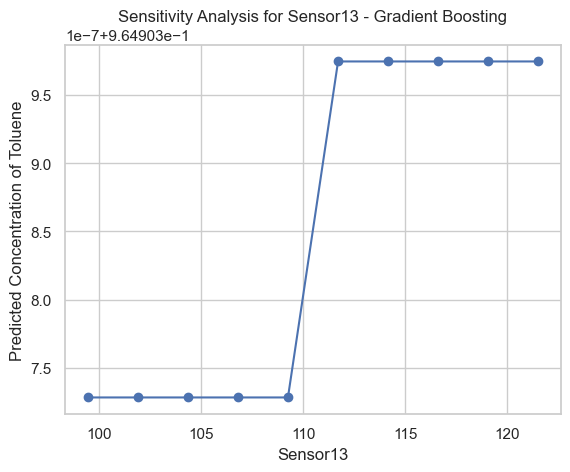

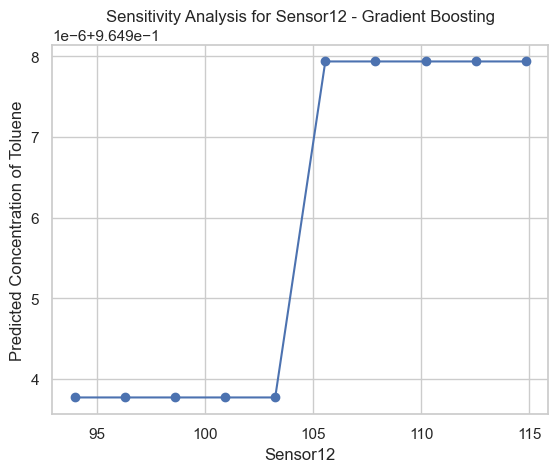

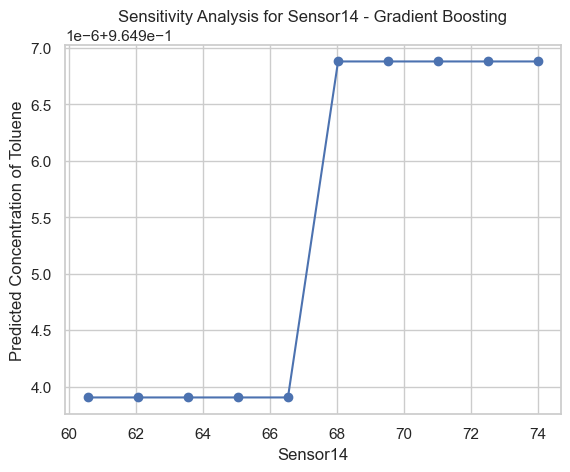

In [ ]:
# Optimization Analysis
constraints = {
  'Sensor15': (0.571794, 1.644580),  
  'Sensor7': (1013.589114, 1084.786368),   
  'Time': (0, 28800),     
  'Sensor1': (48.907668, 50.807513),    
  'Sensor2': (97.702103, 103.848213),    
  'Sensor13': (109.998595, 110.997458),   
  'Sensor12': (103.930595, 104.929458),   
  'Sensor14': (66.819695, 67.818558),   
}

for model_name, model in optimized_models.items():
  print(f"\nOptimization Analysis for {model_name}")

  def objective_function(feature_values):
      feature_df = pd.DataFrame([feature_values], columns=positive_correlated_features)
      predicted_concentration = model.predict(feature_df)[0]
      return -predicted_concentration

  initial_guess = X_test[positive_correlated_features].mean().values
  bounds = [(X_test[feature].min(), X_test[feature].max()) for feature in positive_correlated_features]
  
  result = minimize(objective_function, initial_guess, bounds=bounds, method='L-BFGS-B')
  
  optimal_feature_values = result.x
  optimal_concentration = -result.fun
  
  print("Optimal feature values:", optimal_feature_values)
  print("Predicted maximum concentration:", optimal_concentration)

  optimal_settings = dict(zip(positive_correlated_features, optimal_feature_values))
  print("Optimal Feature Settings:")
  for feature, value in optimal_settings.items():
      print(f"{feature}: {value}")

  feasible = True
  for feature in positive_correlated_features:
      if feature in constraints:
          min_val, max_val = constraints[feature]
          if not (min_val <= optimal_settings[feature] <= max_val):
              feasible = False
              print(f"Warning: {feature} value {optimal_settings[feature]} is out of bounds ({min_val}, {max_val})")
      else:
          print(f"Warning: No constraints defined for {feature}")
  
  if feasible:
      print("All optimal settings are within operational constraints.")

  explainer = shap.TreeExplainer(model) if model_name != 'SVR' else shap.KernelExplainer(model.predict, X_test)
  shap_values = explainer.shap_values(X_test)
  shap.summary_plot(shap_values, X_test, feature_names=positive_correlated_features)
  
  print(f"\nSensitivity Analysis for {model_name}")
  sensitivity_results = {}
  for feature in positive_correlated_features:
      variation = 0.1 * optimal_settings[feature]
      test_values = np.linspace(optimal_settings[feature] - variation, optimal_settings[feature] + variation, 10)
      
      predictions = []
      for value in test_values:
          test_sample = optimal_feature_values.copy()
          feature_index = positive_correlated_features.index(feature)
          test_sample[feature_index] = value
          prediction = model.predict([test_sample])[0]
          predictions.append(prediction)
      
      sensitivity_results[feature] = (test_values, predictions)

      plt.figure()
      plt.plot(test_values, predictions, marker='o')
      plt.title(f"Sensitivity Analysis for {feature} - {model_name}")
      plt.xlabel(feature)
      plt.ylabel('Predicted Concentration of Toluene')
      plt.grid(True)
      plt.show()